## Introduction

The aim of this notebook is to get familiar with **clustering** using **K-means**.

We will be using the [iris dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-dataset).

In [1]:
from sklearn import preprocessing
from sklearn import cluster
from sklearn import datasets 
from sklearn.cluster import AgglomerativeClustering

import numpy as np  
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import colors as clr

from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import dendrogram
from IPython import display

%matplotlib inline

In [2]:
iris = datasets.load_iris()
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

For simplicity we will use `petal length` and `petal width` in this first part.

In [3]:
X = iris.data[:, 2:]
Y = iris.target
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)

print(X.shape, Y.shape)

(150, 2) (150,)


By looking at the data and their corresponding ground truths, we can already identify some clusters.

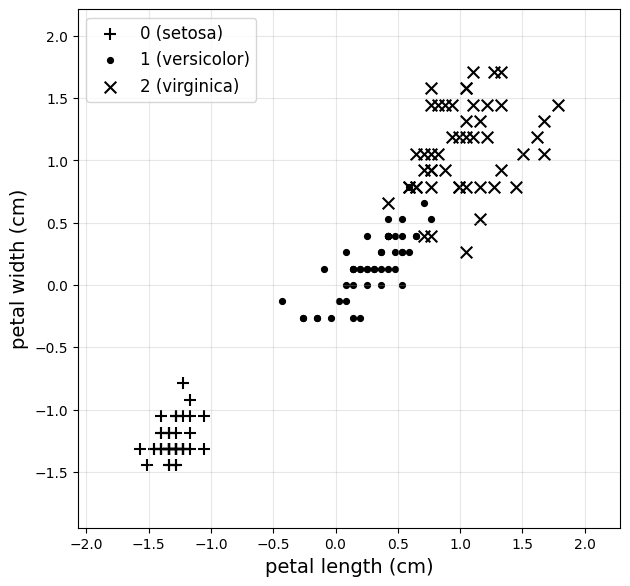

In [4]:
marker_list = ['+', '.', 'x']
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
ax.set_aspect('equal')

for l in [0, 1, 2]:
  ax.scatter(
      X[Y == l, 0],
      X[Y == l, 1],
      marker=marker_list[l],
      s=70,
      color='black',
      label='{:d} ({:s})'.format(l, iris.target_names[l])
      )

ax.legend(fontsize=12)
ax.set_xlabel(iris.feature_names[2], fontsize=14)
ax.set_ylabel(iris.feature_names[3], fontsize=14)
ax.grid(alpha=0.3)
ax.set_xlim(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5)
ax.set_ylim(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5)
plt.show()

# 1. K-means algorithm

This is an iterative algorithm to partition $N$ observations into $K$ clusters.

The two main parts of the algorithm are:

1. E-step: Assign each datum to the closest centroid
2. M-step: Find the new center of each cluster

In [5]:
def distance(x: np.ndarray, mu: np.ndarray) -> np.ndarray:
  """We will use the euclidean distance"""
  x2 = np.sum(x**2, axis=1)
  mu2 = np.sum(mu**2, axis=1)
  xmu = np.matmul(x, mu.T)
  x2 = x2.reshape(-1, 1)
  dist = x2 - 2*xmu + mu2
  return np.sqrt(dist)

def estep(centroids: np.ndarray, x_data: np.ndarray) -> np.ndarray:
  distances = distance(x_data, centroids)
  allocation = np.argmin(distances, axis=1)
  return allocation

def mstep(x_data: np.ndarray, allocation: np.ndarray) -> np.ndarray:
  _ndx = np.argsort(allocation)
  _id, _pos, g_count = np.unique(allocation[_ndx], return_index=True, return_counts=True)
  sum = np.add.reduceat(x_data[_ndx], _pos, axis=0)
  mean = sum/g_count[:, None]
  return mean

In [6]:
def visualize_clusters(X, Y, centroids, allocation):
  display.clear_output(wait=True)
  colors = ['#CBAACB', '#F6EAC2', '#97C1A9']
  fig = plt.figure(figsize=(7, 7))
  ax = fig.add_subplot(111)
  ax.set_aspect('equal')
  for l in [0, 1, 2]:
      idx = Y == l
      c = allocation[idx]
      cmap = clr.ListedColormap(colors, N=3)
      ranges = np.linspace(0, 2, len(colors)+1)
      norm = clr.BoundaryNorm(ranges, cmap.N)
      print(X.shape, Y.shape, c.shape)
      ax.scatter(
          X[idx, 0],
          X[idx, 1],
          marker=marker_list[l],
          s=70,
          c=c,
          label='{:d} ({:s})'.format(l, iris.target_names[l]),
          cmap=cmap,
          norm=norm
          )
  #plot centroids
  plt.scatter(
      centroids[:, 0],
      centroids[:, 1],
      marker='^',
      c=colors,
      s=70,
      )
  #plot lines
  for idx, datum in enumerate(X):
    calloc = allocation[idx]
    cen = centroids[calloc]
    x_dat = [datum[0], cen[0]]
    y_dat = [datum[1], cen[1]]
    plt.plot(x_dat, y_dat, alpha=0.2, c=colors[calloc])

  ax.legend(fontsize=12)
  ax.set_xlabel(iris.feature_names[2], fontsize=14)
  ax.set_ylabel(iris.feature_names[3], fontsize=14)
  ax.grid(alpha=0.3)
  ax.set_xlim(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5)
  ax.set_ylim(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5)
  plt.show()

Puting everything together:

* Initialize $K$ random centroids
* Repeat E-M steps for $I$ number of iterations

(150, 2) (150,) (50,)
(150, 2) (150,) (50,)
(150, 2) (150,) (50,)


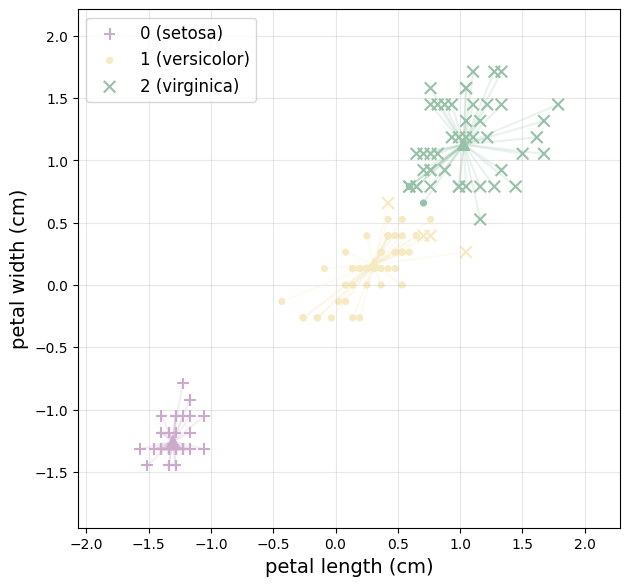

In [7]:
iterations = 10
K = 3
dimensions = X.shape[1]

# Initialize K random centroids
centroids = np.random.rand(K, dimensions) * 4 - 2 #random centroids between [-2,2]
# for I number of iterations
for i in range(iterations):
  allocation = estep(centroids, X)
  centroids = mstep(X, allocation)
  visualize_clusters(X, Y, centroids, allocation)

# 2. Selecting $K$ (Elbow curve)
In the iris example, we have some prior knowledge about the different species which informs our decision on K. This is not always the case, in which case we need a way of selecting $K$.

In [8]:
K = range(1, 10)
cost = list()
for k in K:
  model = cluster.KMeans(n_clusters=k)
  model.fit(X)
  cost.append(
      sum(np.min(cdist(X, model.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0]
  )

Plot the cost against number of clusters. 

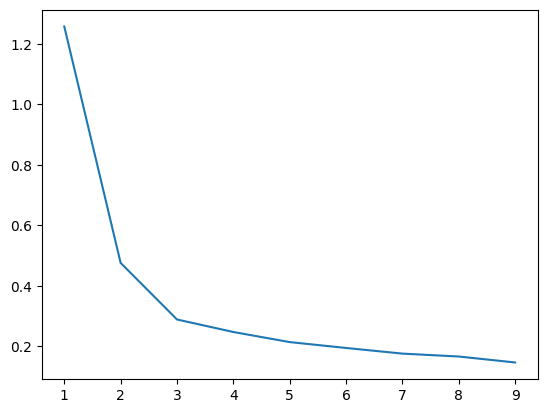

In [9]:
plt.plot(K,cost)

### Using the elbow method we observe that the optimal number of $K$ is 3

Now using all of the attributes, repeat the elbow curve method to select the optimal $K$. 

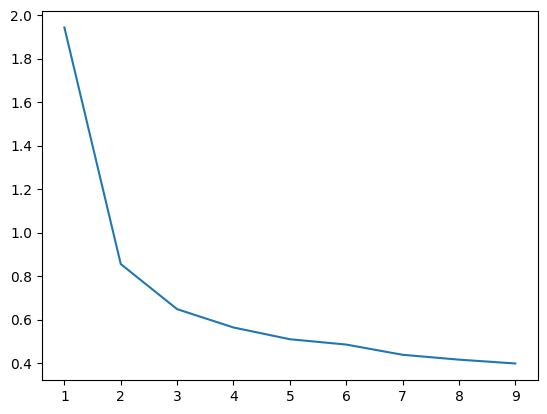

In [10]:
X = iris.data

K = range(1, 10)
cost = list()
for k in K:
  model = cluster.KMeans(n_clusters=k)
  model.fit(X)
  cost.append(
      sum(np.min(cdist(X, model.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0]
  )

plt.plot(K,cost)

# 3. Hierarchical Clustering
In this section we will look into a Hierarchical clustering algorithm.
We will be using the [AgglomerativeClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html?highlight=agglomerative) class from sklearn.

First, spend some time to read the API and understand the model parameters.
Then, fit a model to $X$


In [11]:
clustering = AgglomerativeClustering(compute_distances = True).fit(X) 

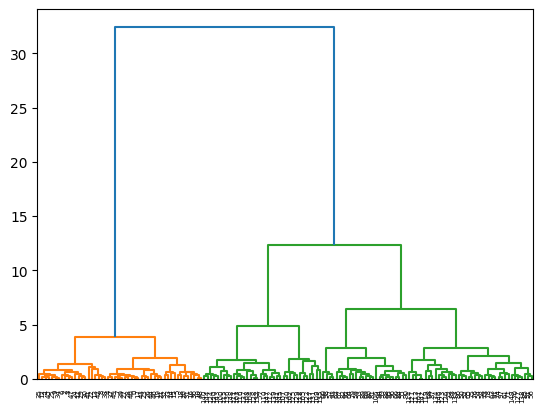

In [12]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    dendrogram(linkage_matrix, **kwargs)


plot_dendrogram(clustering)

# 4. Segmentation Example

In this section we will use the `ifood_df.csv` dataset, which consists of 2206 customers of XYZ company with data on:

*    Customer profiles
*    Product preferences
*    Campaign successes/failures
*    Channel performance 

In [13]:
ifood = pd.read_csv('ifood_df.csv')

We will only use the following columns:
`['Income', 'Age', 'Recency', 'MntWines',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntRegularProds','MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'MntTotal'
       ]`

In [14]:
ifood = ifood[['Income', 'Age', 'Recency', 'MntWines',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntRegularProds','MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'MntTotal'
      ]]

We will train a Kmeans clustering algorithm.

Using the elbow method, we find the optimal number of $K$ and plot the elbow curve and train a model for the optimal number of $K$.

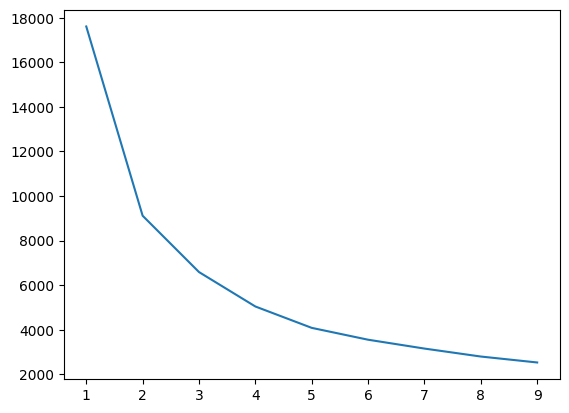

In [15]:
### elbow curve 
K = range(1, 10)
cost = list()
for k in K:
  model = cluster.KMeans(n_clusters=k)
  model.fit(ifood)
  cost.append(
      sum(np.min(cdist(ifood, model.cluster_centers_, 'euclidean'), axis=1)) / ifood.shape[0]
  )

plt.plot(K,cost)



In [16]:
### train model for optimal K
k = 5 
model = cluster.KMeans(n_clusters=k)
model.fit(ifood)

ifood['kmeans_cluster'] = model.labels_

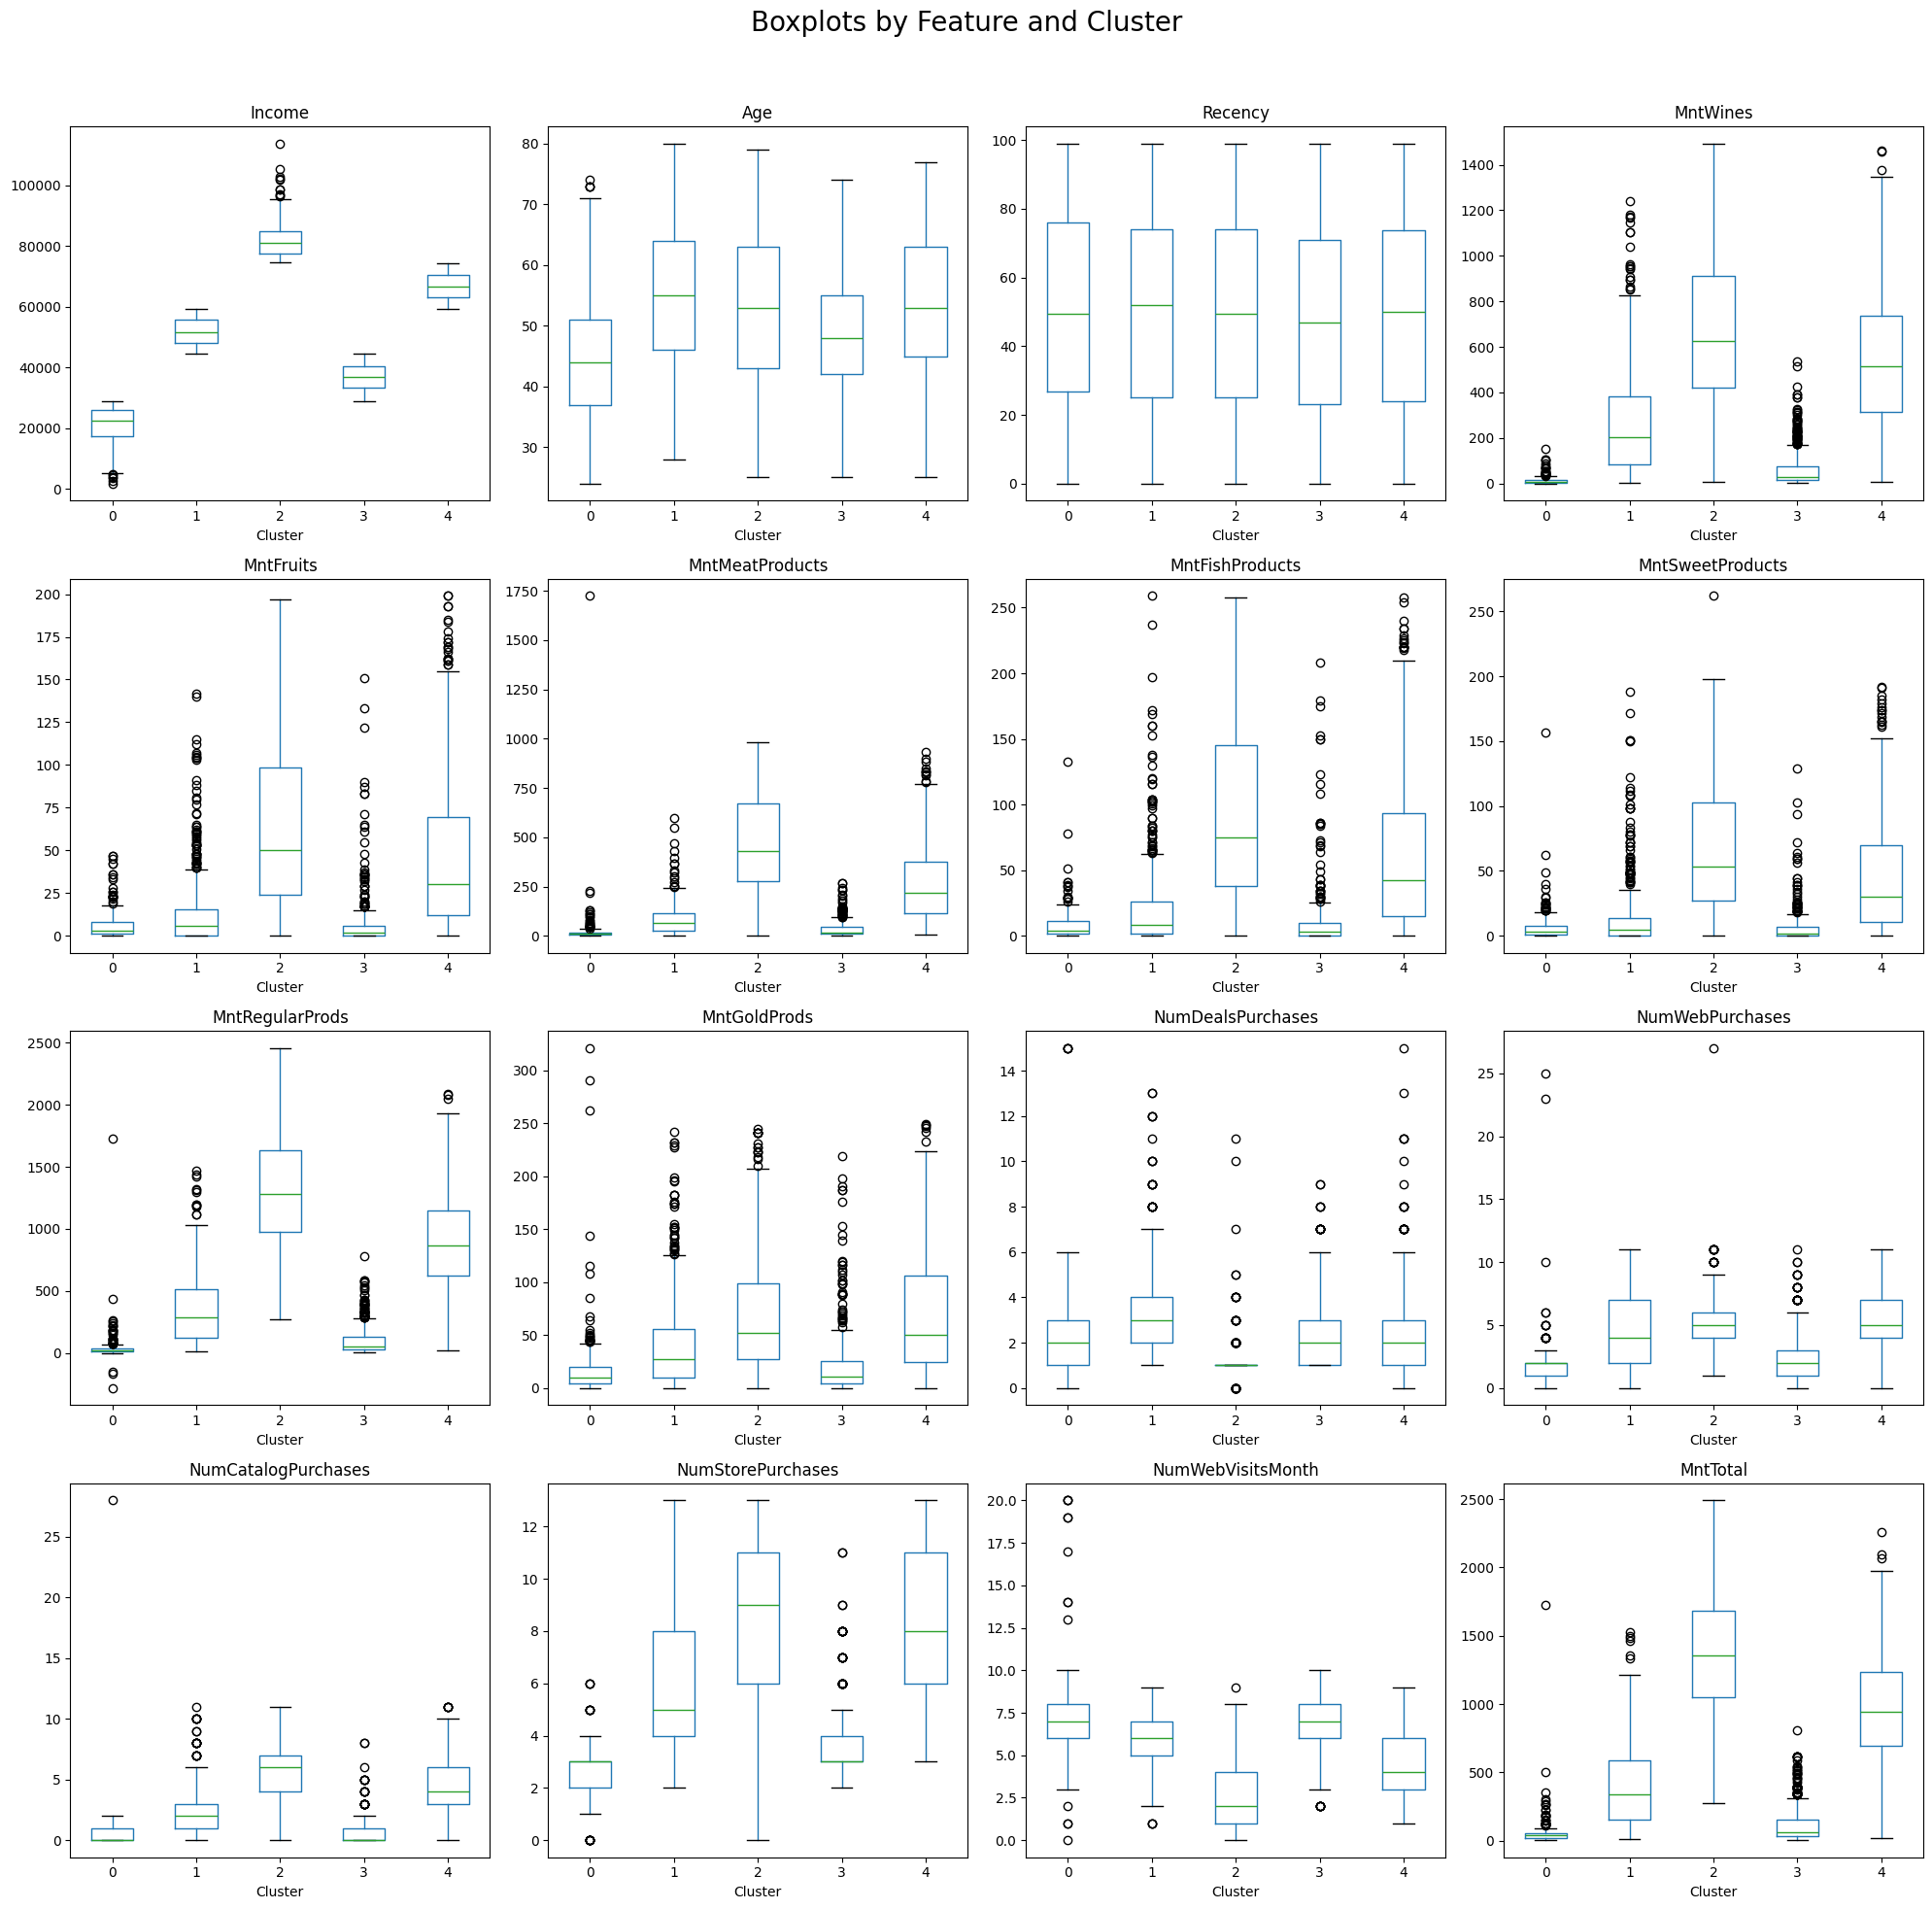

In [17]:
feature_columns = [col for col in ifood.columns if col != 'kmeans_cluster']
n_rows, n_cols = 4, 4  # 4x4 grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))  

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Create boxplots for each feature
for i, feature in enumerate(feature_columns):
    ifood.boxplot(column=feature, by='kmeans_cluster', grid=False, ax=axes[i])
    axes[i].set_title(f'{feature}')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel('')
    
# Remove empty subplots if there are any
for j in range(len(feature_columns), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Boxplots by Feature and Cluster', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96]) 

Now looking at the clusters along each dimension we can assess whether all features are equally important in separating the customers into clusters.